In [17]:
import sympy as sym
from os import path
import sympy.physics.mechanics as me
from sympy.abc import t
import moyra as ma
me.mechanics_printing()

In [18]:
DoFs = 3
# heave and fold angle as degrres of freedom
p = ma.DynamicModelParameters(DoFs)
p.DoFs  = ma.ModelSymbol(value = DoFs,string = 'DoFs')
#gravity vector
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point
p.alpha = ma.ModelSymbol(value = 0,string = 'alpha')                     # AoA
p.beta = ma.ModelSymbol(value = 0,string = 'beta')                     # SideSlip
p.v_c = ma.ModelMatrix(value =[0,0,0],length=3,string='v_c') # The stationary point
p.v_h = ma.ModelMatrix(value =[0,0,0],length=3,string='v_h') # The stationary point
p.m = ma.ModelSymbol(value = 0,string = 'm') # The stationary point
p.I_xx = ma.ModelSymbol(value = 0,string = 'I_xx') # The stationary point
p.I_yy = ma.ModelSymbol(value = 0,string = 'I_yy') # The stationary point
p.I_zz = ma.ModelSymbol(value = 0,string = 'I_zz') # The stationary point
p.Lambda = ma.ModelSymbol(value = 0,string = 'Lambda') # The stationary point
p.Wrench = ma.ModelMatrix(value =[0]*6,length=6,string='W') # The stationary point

y_0,x_0,z_0 = sym.symbols('y_0,x_0,z_0')
F_x,F_y,F_z,M_x,M_y,M_z = sym.symbols('F_x,F_y,F_z,M_x,M_y,M_z')

In [19]:
# fwt_frame = ma.frames.HomogenousFrame().R_y(p.q[0]).R_z(p.q[1]).R_x(p.q[2]).simplify()
fwt_frame = ma.frames.ReferenceFrame.EulerAnglesXYZ(p.v_h,p.q[:3])
body_frame = ma.frames.HomogenousFrame().R_z(p.beta).R_y(p.alpha).simplify()
hinge_frame = body_frame.Translate(*p.v_h).R_z(p.Lambda).simplify()

In [20]:
test = [*p.v_h,*p.q]
[False if not isinstance(i,sym.Function) else i.args[0] == t  for i in test ]

[False, False, False, True, True, True]

In [21]:
#Create Elemnts
M = ma.elements.MassMatrix(p.m,p.I_xx,p.I_yy,0,0,0,0)
## FWT mass element
fwt_ele = ma.elements.RigidElement(p.q, fwt_frame, M, grav_vec=p.g_v*p.g, com_pos=p.v_c, name='fwt')

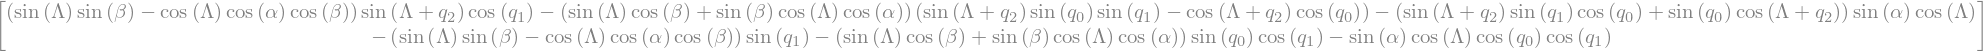

In [22]:
C =[]
# xyz = sym.simplify(hinge_frame.transform_point([0,0,0])-fwt_frame.transform_point([0,0,0]))
ydot = sym.simplify(hinge_frame.transform_vector([1,0,0]).T*fwt_frame.transform_vector([-sym.sin(p.Lambda),sym.cos(p.Lambda),0]))
zdot = sym.simplify(hinge_frame.transform_vector([1,0,0]).T*fwt_frame.transform_vector([0,0,1]))
# C = sym.BlockMatrix([[xyz],[ydot],[zdot]]).as_explicit()
C = sym.BlockMatrix([[ydot],[zdot]]).as_explicit()
C

In [23]:
sm = ma.SymbolicModel.FromElementsAndForces(p.q,[fwt_ele],C=C)

Generating EoM for Element 1 out of 1 - fwt:RigidElement


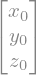

In [24]:
sym.simplify(fwt_ele.frame.transform_point(fwt_ele.frame.transform_global_point([x_0,y_0,z_0])))

In [33]:
funcs = []
fwt_pos = [x_0,y_0,z_0]
funcs.append(('get_fwt_V_b',fwt_ele.frame.A.T*fwt_ele.frame.transform_point([x_0,y_0,z_0]).diff(t)))
funcs.append(('get_pos_fwt',fwt_ele.frame.transform_global_point([x_0,y_0,z_0])))
funcs.append(('get_fwt_V_b_body',body_frame.A.T*fwt_ele.frame.transform_point([x_0,y_0,z_0]).diff(t)))
funcs.append(('get_fwt_A',fwt_ele.frame.A))
funcs.append(('get_body_A',body_frame.A))

In [34]:
#create function for an arbitary force of FWT
F_x,F_y,F_z,M_x,M_y,M_z = sym.symbols('F_x,F_y,F_z,M_x,M_y,M_z')
W = sym.Matrix([F_x,F_y,F_z,M_x,M_y,M_z])
fwt_Q_tmp = fwt_ele.frame.BodyJacobian(p.q,sym.Matrix(fwt_pos)).T*W
idx = [i for i, e in enumerate(p.q) if e in fwt_ele.q]
fwt_Q = sym.zeros(len(p.q),1)
for i,i_fwt in zip(idx,fwt_ele._idx):
    fwt_Q[i] += fwt_Q_tmp[i_fwt]
funcs.append(('get_fwt_Q',fwt_Q))

In [35]:
#create function for a moment about the hinge
M_h = sym.symbols('M_h')
tt = ma.frames.HomogenousFrame().R_z(p.Lambda);
M = tt.A*sym.Matrix([M_h,0,0])
W = sym.Matrix([0,0,0,*M])
fwt_Q_tmp = fwt_ele.frame.BodyJacobian(p.q,sym.Matrix([0]*3)).T*W
idx = [i for i, e in enumerate(p.q) if e in fwt_ele.q]
fwt_Q = sym.zeros(len(p.q),1)
for i,i_fwt in zip(idx,fwt_ele._idx):
    fwt_Q[i] += fwt_Q_tmp[i_fwt]
funcs.append(('get_hinge_Q',fwt_Q))

In [36]:
hinge_normal = sym.Matrix([0,0,1])
fwt_normal = fwt_frame.transform_vector([0,0,1])
fwt_hinge_vector = fwt_frame.transform_vector([sym.cos(p.Lambda),sym.sin(p.Lambda),0])
fold = -sym.atan2(hinge_normal.cross(fwt_normal).dot(fwt_hinge_vector),hinge_normal.dot(fwt_normal))
fold_dt = fold.diff(t)
funcs.append(('get_fold',fold))
funcs.append(('get_fold_dt',fold_dt))

In [38]:
base_dir = "D:\\AlphaBetaData\\EoM"
class_name = "OneDof_fwt"
base_class = "mbd.BaseMBD"
sm.to_matlab_class(p,base_dir,class_name,base_class,additional_funcs=funcs)

Unknown variable z_0 found in function get_fwt_V_b. It will be added to the function signature.
Unknown variable x_0 found in function get_fwt_V_b. It will be added to the function signature.
Unknown variable y_0 found in function get_fwt_V_b. It will be added to the function signature.
Unknown variable z_0 found in function get_pos_fwt. It will be added to the function signature.
Unknown variable y_0 found in function get_pos_fwt. It will be added to the function signature.
Unknown variable x_0 found in function get_pos_fwt. It will be added to the function signature.
Unknown variable z_0 found in function get_fwt_V_b_body. It will be added to the function signature.
Unknown variable y_0 found in function get_fwt_V_b_body. It will be added to the function signature.
Unknown variable x_0 found in function get_fwt_V_b_body. It will be added to the function signature.
Unknown variable z_0 found in function get_fwt_Q. It will be added to the function signature.
Unknown variable M_y found 